In [1]:
%matplotlib inline
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import scipy.stats as stats
import statsmodels.api as sm
import gdown


In [2]:
# Define the ticker and date range
ticker = "BMRI.JK"
start_date = "2014-01-01"
end_date = "2024-11-13"

# Fetch data
data_csv = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Reset index to make the date a regular column, not the index
data_csv = data_csv.reset_index()

# Display the first few rows to confirm
print(data_csv.tail())

# Optionally, save the data to a CSV file
data_csv.to_csv("BBRI_JK.csv", index=False)

data = data_csv[data_csv.columns[1:5]]

# Calculate 95% of the total number of rows
num_rows = int(0.95 * len(data))

# Select the first 95% of rows
obs = data.iloc[:num_rows]
# Remove any rows with missing values
obs = obs.dropna()

# Print the monthly data
print(obs)
print(data)

[*********************100%***********************]  1 of 1 completed
           Date    Open    High     Low   Close  Adj Close     Volume
2683 2024-11-06  6925.0  6925.0  6550.0  6550.0     6550.0  147272800
2684 2024-11-07  6500.0  6550.0  6425.0  6425.0     6425.0  154758500
2685 2024-11-08  6425.0  6525.0  6275.0  6325.0     6325.0  192423000
2686 2024-11-11  6300.0  6450.0  6150.0  6350.0     6350.0  125606000
2687 2024-11-12  6375.0  6450.0  6325.0  6375.0     6375.0  117281700
        Open     High     Low    Close
0     1975.0  2025.00  1962.5  2025.00
1     2012.5  2025.00  1937.5  1950.00
2     1950.0  1962.50  1900.0  1912.50
3     1912.5  1931.25  1900.0  1906.25
4     1925.0  1962.50  1912.5  1956.25
...      ...      ...     ...      ...
2548  6725.0  6800.00  6650.0  6725.00
2549  6875.0  6875.00  6575.0  6725.00
2550  6850.0  6925.00  6725.0  6825.00
2551  6925.0  7050.00  6900.0  7050.00
2552  7050.0  7075.00  6925.0  6950.00

[2553 rows x 4 columns]
        Open     H

In [3]:

T = 120
AIC, BIC, HQC, CAIC = [], [], [], []

for n in range(2, 7):
    a, b, c, d = [], [], [], []
    first_time = True

    for i in range(0, T):
        
        if first_time:
            model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
            first_time = False
        else:
            old_model = model
            model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

            # Normalize startprob_ to ensure it sums to 1
            model.startprob_ = model.startprob_ / np.sum(model.startprob_)

            # Ensure transition matrix rows sum to 1
            model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

            # If any row sums to 0, reinitialize it to uniform probabilities
            for row in range(n):
                if np.sum(model.transmat_[row]) == 0:
                    model.transmat_[row] = np.full(n, 1 / n)

        # Fit the model using the data
        model.fit(obs[i:i+T])

        log_likelihoods = model.score(obs[i:i+T])
        k = n**2 + 2*n - 1

        aic = -2 * log_likelihoods + 2 * k
        bic = -2 * log_likelihoods + k * np.log(4 * T)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)


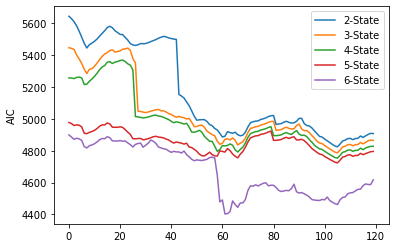

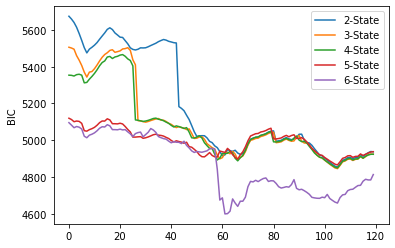

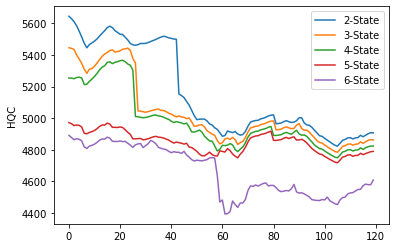

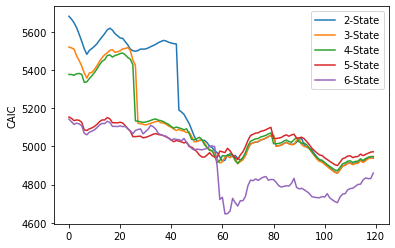

In [4]:

# Plot AIC values for different numbers of components
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.ylabel("AIC")
plt.legend()
plt.savefig(f"{ticker}_AIC_plot.png")  # Save the AIC plot with the ticker in the filename
plt.show()

# Plot BIC values for different numbers of components
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.ylabel("BIC")
plt.legend()
plt.savefig(f"{ticker}_BIC_plot.png")  # Save the BIC plot with the ticker in the filename
plt.show()

# Plot HQC values for different numbers of components
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.ylabel("HQC")
plt.legend()
plt.savefig(f"{ticker}_HQC_plot.png")  # Save the HQC plot with the ticker in the filename
plt.show()

# Plot CAIC values for different numbers of components
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.ylabel("CAIC")
plt.legend()
plt.savefig(f"{ticker}_CAIC_plot.png")  # Save the CAIC plot with the ticker in the filename
plt.show()


In [5]:
#KEPAKE
obs = data.iloc[:num_rows]
first_time = True
n=6
T = 120
w = int(len(obs)*0.9/0.95) - T
likelihood_list = []  

# Creating Likelihood from trained data
for i in range(0, w):
    
    np.random.seed(1234)
    
    if first_time:
        model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=1000)
        first_time = False
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=1000)

        # Ensure model parameters match the expected number of components
        model.startprob_ = np.zeros(n)  # Initialize with zeros
        model.transmat_ = np.zeros((n, n))  # Initialize with zeros
        model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
        if old_model.startprob_.shape[0] == n:
            model.startprob_ = old_model.startprob_
        if old_model.transmat_.shape == (n, n):
            model.transmat_ = old_model.transmat_
        if old_model.means_.shape[0] == n:
            model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
        model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
        model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
        for row in range(n):
            if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
                model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
        if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
            print("Invalid parameters detected, reinitializing...")
            model.startprob_ = np.full(n, 1 / n)
            model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[i:i+T])
    likelihoods = model.score(obs[i:i+T])
    likelihood_list.append(likelihoods)  # Append the likelihood directly


In [6]:
num_test=int(0.05*len(data))
# Select the first 95% of rows
obs = data.iloc[:num_rows]
# Remove any rows with missing values
obs = obs.dropna()

for i in range (num_test) :
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=1000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = obs['Close'].iloc[-1] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = obs['Open'].iloc[-1] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = obs['High'].iloc[-1] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = obs['Low'].iloc[-1] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -3345.1111793978694 is -3345.5071615917873 at index 1550.
 iteration 1The closest likelihood value to -3348.414557601233 is -3345.5071615917873 at index 1550.
 iteration 2The closest likelihood value to -3351.6903411960893 is -3351.7612252145104 at index 2079.
 iteration 3The closest likelihood value to -3355.2682772909598 is -3356.1062305927558 at index 1448.
 iteration 4The closest likelihood value to -3359.071484084163 is -3360.197101062208 at index 1549.
 iteration 5The closest likelihood value to -3363.6366604535924 is -3361.8103290184204 at index 2080.
 iteration 6The closest likelihood value to -3367.0252742572156 is -3367.1899801752625 at index 2122.
 iteration 7The closest likelihood value to -3367.862315107423 is -3367.1899801752625 at index 2122.
 iteration 8The closest likelihood value to -3368.1825427087697 is -3368.9552934792478 at index 2081.
 iteration 9The closest likelihood value to -3369.726866284619 is -3368.9552934792478 

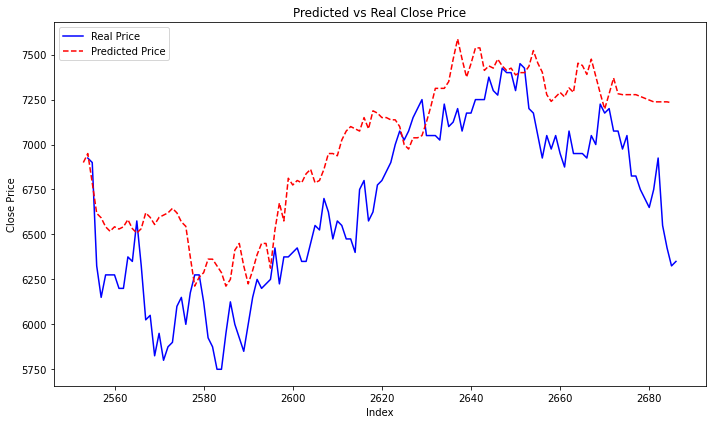

In [7]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]
real_price = data["Close"].iloc[-(num_test):-1]

# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot real prices
plt.plot(real_price.index, real_price, label='Real Price', color='blue')

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Predicted vs Real Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(real_price.min()), int(real_price.max()) + 250, 250))
plt.savefig(f"{ticker}_Prediction.png")  # Sav
# Show plot
plt.tight_layout()
plt.show()


In [8]:
mape = (abs((real_price - predicted_price) / real_price)).mean() * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

Mean Absolute Percentage Error (MAPE): 4.988%


In [9]:
real_price

2554    6925.0
2555    6900.0
2556    6325.0
2557    6150.0
2558    6275.0
         ...  
2682    6925.0
2683    6550.0
2684    6425.0
2685    6325.0
2686    6350.0
Name: Close, Length: 133, dtype: float64

In [10]:
predicted_price

2553    6900.0
2554    6950.0
2555    6787.5
2556    6617.5
2557    6592.5
         ...  
2681    7237.5
2682    7237.5
2683    7237.5
2684    7237.5
2685    7232.5
Name: Close, Length: 133, dtype: float64

In [11]:
#Out of Sample

obs = data
first_time = True
T = 120
w = int(len(obs)*0.95/0.95) - T
likelihood_list = []  

# Creating Likelihood from trained data
for i in range(0, w):
    
    np.random.seed(1234)
    
    if first_time:
        model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
        first_time = False
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

        # Ensure model parameters match the expected number of components
        model.startprob_ = np.zeros(n)  # Initialize with zeros
        model.transmat_ = np.zeros((n, n))  # Initialize with zeros
        model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
        if old_model.startprob_.shape[0] == n:
            model.startprob_ = old_model.startprob_
        if old_model.transmat_.shape == (n, n):
            model.transmat_ = old_model.transmat_
        if old_model.means_.shape[0] == n:
            model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
        model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
        model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
        for row in range(n):
            if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
                model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
        if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
            print("Invalid parameters detected, reinitializing...")
            model.startprob_ = np.full(n, 1 / n)
            model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[i:i+T])
    likelihoods = model.score(obs[i:i+T])
    likelihood_list.append(likelihoods)  # Append the likelihood directly


In [12]:
for i in range (num_test) :
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=1000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = obs['Close'].iloc[-1] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = obs['Open'].iloc[-1] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = obs['High'].iloc[-1] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = obs['Low'].iloc[-1] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -3430.172200975703 is -3430.1921382306928 at index 2489.
 iteration 1The closest likelihood value to -3425.3879489191077 is -3425.2280271716654 at index 2516.
 iteration 2The closest likelihood value to -3423.1180046106033 is -3422.9095947212777 at index 2092.
 iteration 3The closest likelihood value to -3422.279720978758 is -3422.865727085793 at index 2514.
 iteration 4The closest likelihood value to -3419.0973564311425 is -3420.1798307153217 at index 2117.
 iteration 5The closest likelihood value to -3416.674507344265 is -3416.8309910793064 at index 2401.
 iteration 6The closest likelihood value to -3415.629357087575 is -3416.8309910793064 at index 2401.
 iteration 7The closest likelihood value to -3415.354810884728 is -3416.8309910793064 at index 2401.
 iteration 8The closest likelihood value to -3414.3908873123273 is -3412.41548928589 at index 2089.
 iteration 9The closest likelihood value to -3409.846551381864 is -3409.9088755590506 at i

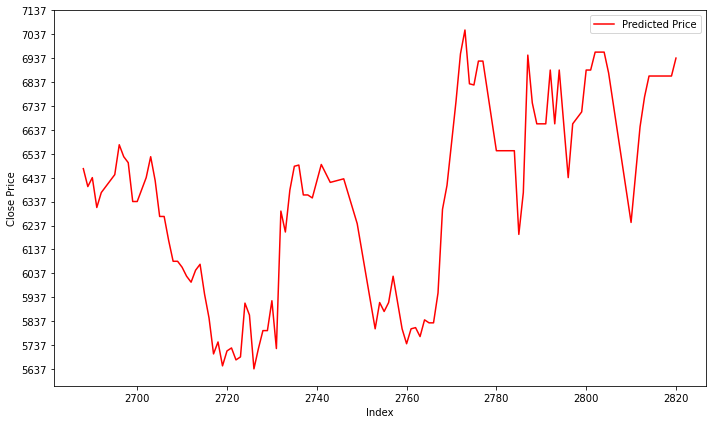

In [13]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]


# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='-')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(predicted_price.min()), int(predicted_price.max()) + 100, 100))
plt.savefig(f"{ticker}_Prediction_Out.png")
# Show plot
plt.tight_layout()
plt.show()
